In [167]:
%reset
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # high res plotting

import numpy as np
import pandas as pd

# voytek lab tools
from neurodsp import spectral # for making PSD
from neurodsp import filt # for filtering

from fooof import FOOOF # fooof!
# cycle-by-cycle
from bycycle.features import compute_features
from bycycle.burst import plot_burst_detect_params

# plotting stuff
import seaborn as sns # not necessary but I like seaborn
sns.set_style('whitegrid')

import matplotlib
import matplotlib.pyplot as plt

# plot settings
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'regular',
        'size'   : 13}
figure = {'figsize' : (20,8)}

matplotlib.rc('font', **font)
matplotlib.rc('figure', **figure)


Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
filename = 'hemiparkinsonianRat.npy' # provided file

fs = 2000 # told via email

data = np.load(filename)

N = len(data) # number of channels
T = len(data[1])/fs # length of each channel
t = np.arange(0, T, 1/fs) # channel lenght to time

print(data.shape)

(4, 20000)


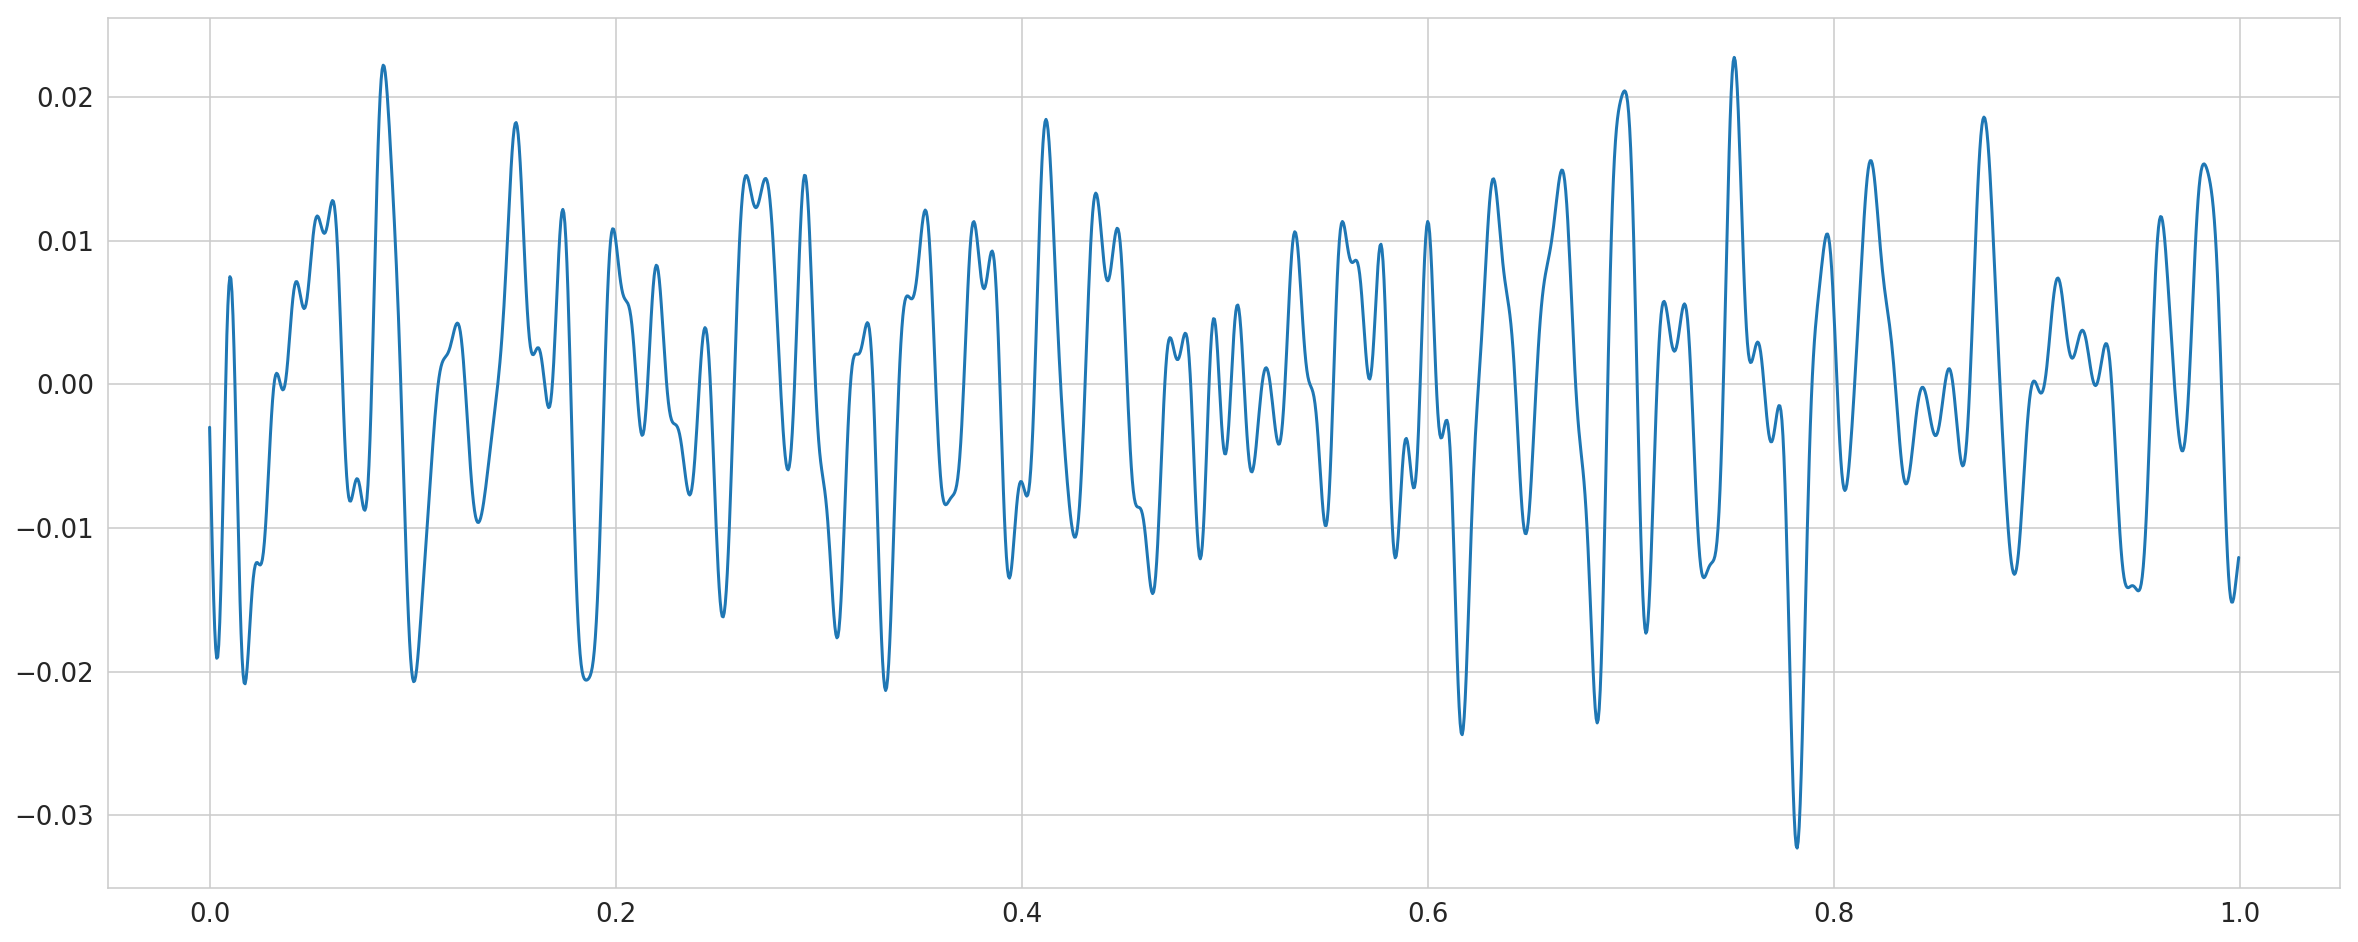

In [169]:
# take a look
plt.plot(t[0:2000], data[0, 0:2000])
plt.show()

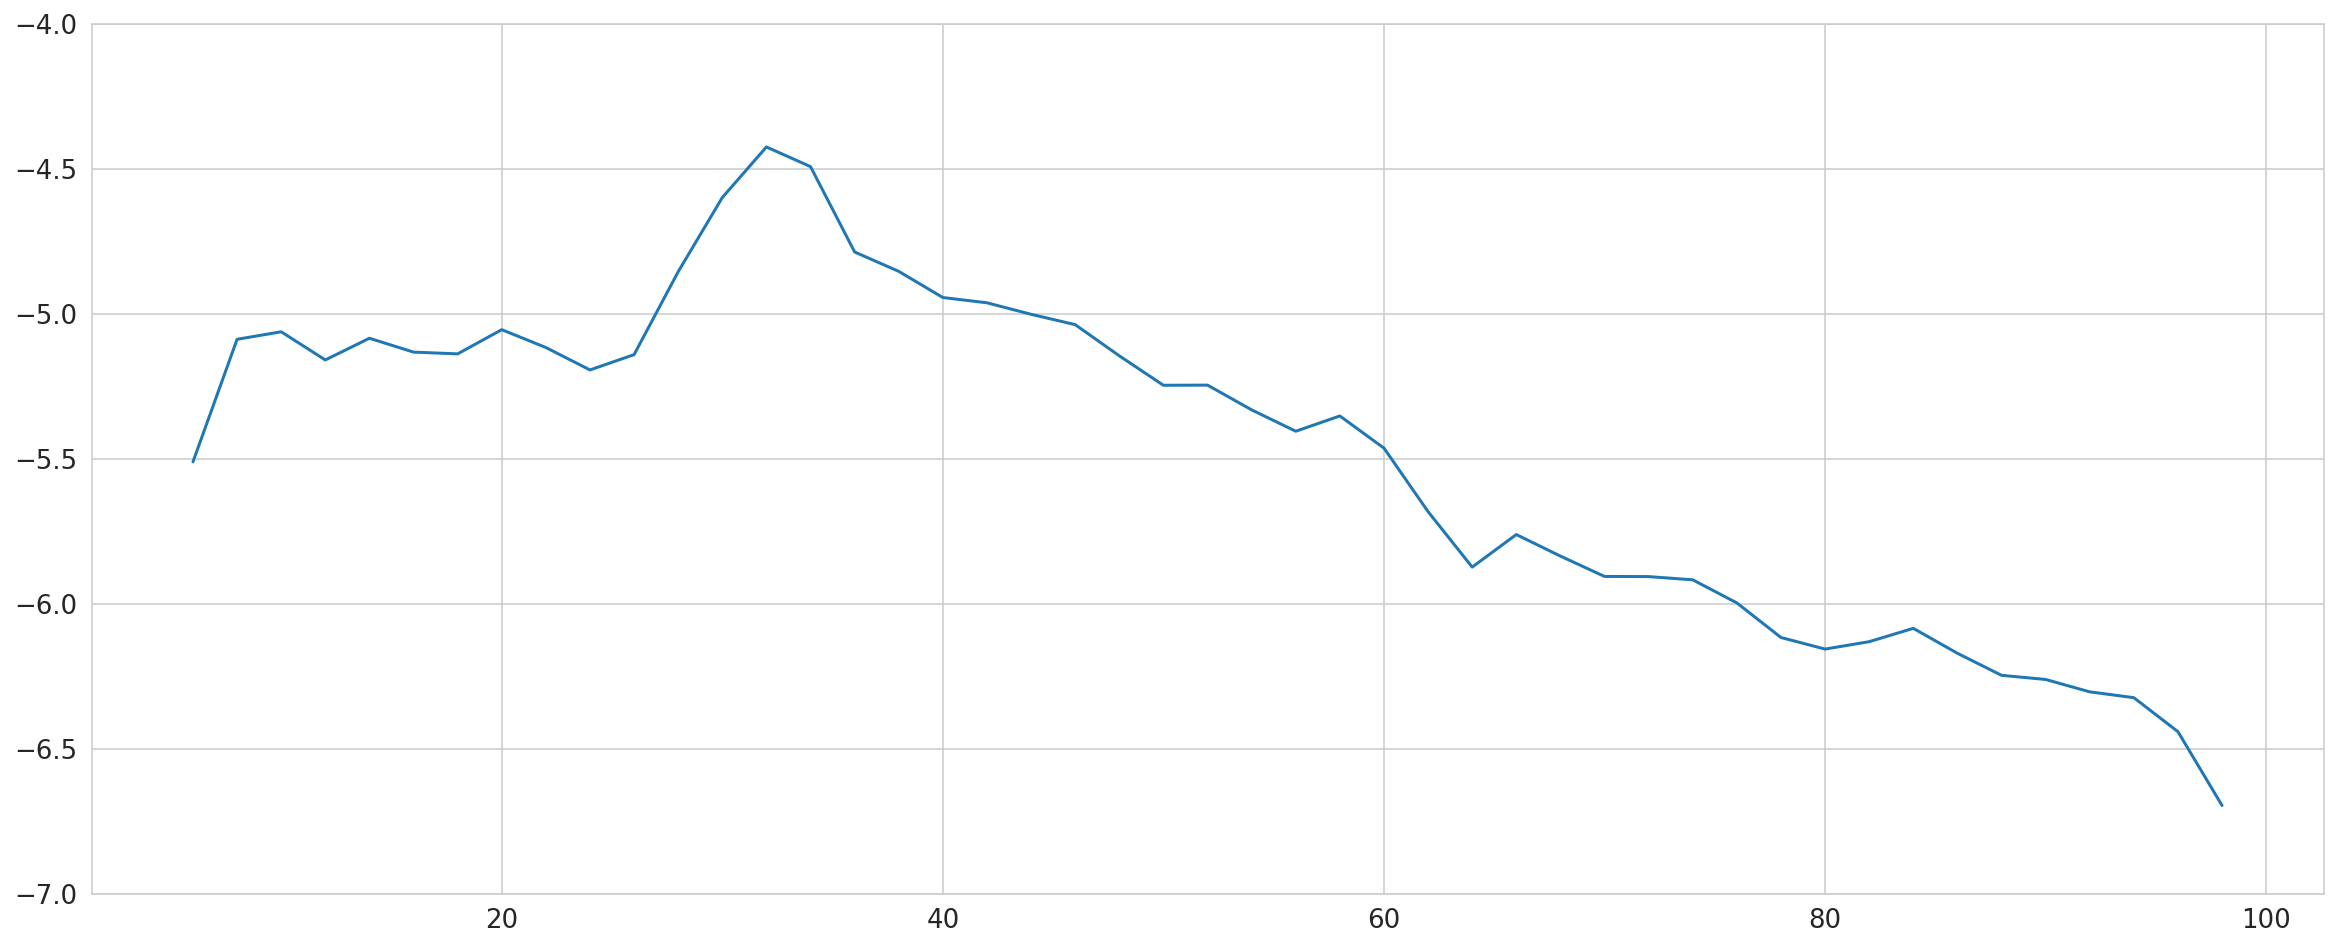

In [170]:
# get the spectra for each channel
pxx = []

for i in range(data.shape[0]):
    fxx, temp = spectral.compute_spectrum(data[i,:], fs, method='welch', avg_type='mean', nperseg=fs/2)
    
    pxx.append(temp)

pxx = np.asarray(pxx)
mean_pxx = np.mean(pxx,0)

plt.plot(fxx[3:50], np.log10(mean_pxx[3:50]))
plt.ylim((-7, -4)) # scale the spectrum a bit
plt.show()


## There's a clear spectral peak in most of the channels at around 30 Hz. Also looks like there's a low-pass filter at around 4-6 Hz, and a high-pass filter around 120 Hz.

## I'll use fooof next to find the more precise spectral peak.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 2.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 8 - 90 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offs

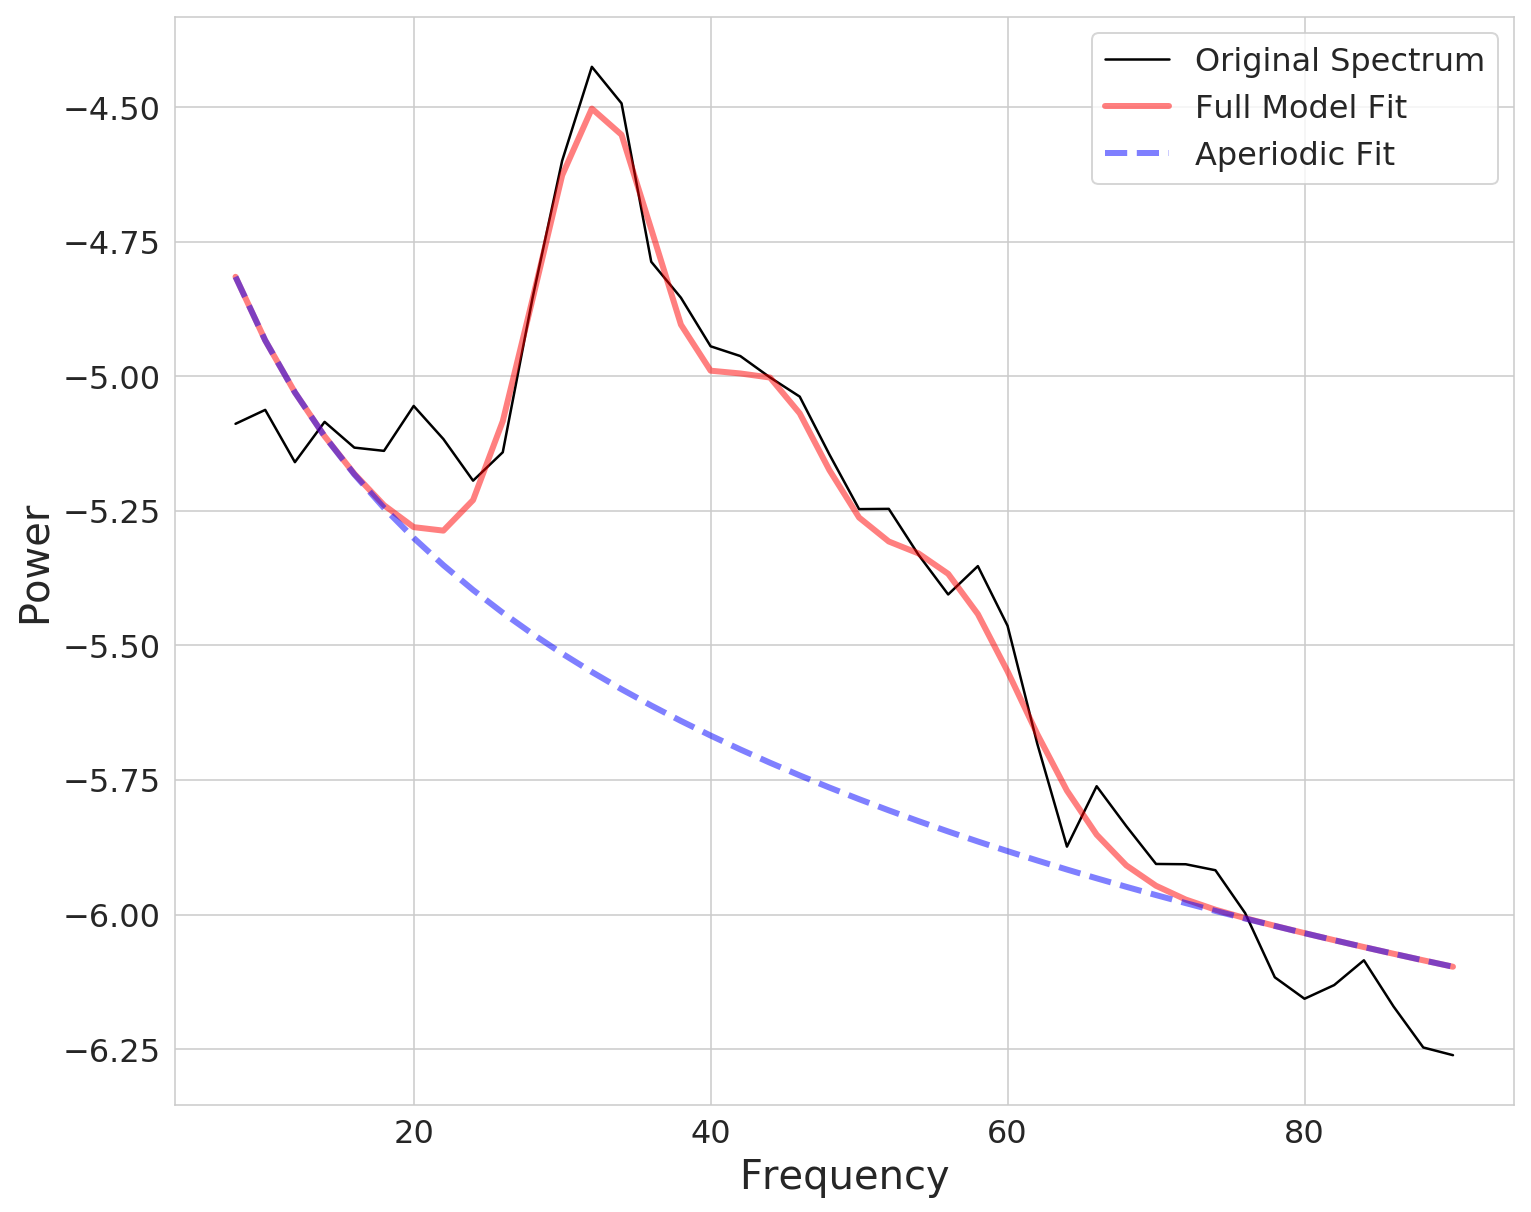

In [172]:
# Initialize FOOOF model
fm = FOOOF()

# Set the frequency range upon which to fit FOOOF
# I'm using this range because of the filters
freq_range = [7, 90]

# Run FOOOF model - calculates model, plots, and prints results
# note this is done here for the _avergage_ spectrum of all channels
fm.report(fxx, mean_pxx, freq_range)

## It's interesting that fooof finds peaks at around 33, 44, and 55 Hz, which are all harmonics of 11 Hz, but there's no 11 or 22 Hz signal.

## Does hint at some non-sinusoidality, though.

In [174]:
# find the oscillation with the largest peak, from fooof
peak_osc = np.argmax(fm.peak_params_[:,1])

# get the center freq, power, and bandwidth of that largest peak
osc_params = fm.peak_params_[peak_osc,:]

print(osc_params)

# frequency band of interest
# this is the center freq -/+ bandwidth of the largest
    # power oscillation found by fooof
osc = ((osc_params[0]-osc_params[2]), (osc_params[0]+osc_params[2]))

print(osc)

[32.54937262  1.04693087  8.93467872]
(23.61469389559798, 41.48405134412188)


In [175]:
# low-pass filter
fc = 50

signals = []
# Apply lowpass filter to each signal
for i in range(len(data)):
    temp = filt.filter_signal(data[i,:], fs, 'lowpass', (None, fc))
    signals.append(temp)
signals = np.asarray(signals)

burst_kwargs = {'amplitude_fraction_threshold': .2,
                'amplitude_consistency_threshold': .2,
                'period_consistency_threshold': .5,
                'monotonicity_threshold': .8,
                'N_cycles_min': 3} # Tuned burst detection parameters

# Compute features for each signal and concatenate into single dataframe
dfs = []
for i in range(N):
    df = compute_features(signals[i,:], fs, osc,
                          burst_detection_kwargs=burst_kwargs)
    df['chan_id'] = i
    dfs.append(df)
df_cycles = pd.concat(dfs)

print(df_cycles.head())

/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/bycycle/cyclepoints.py:123: RuntimeWarning: invalid value encountered in less
  pos = data < 0
/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/bycycle/cyclepoints.py:117: RuntimeWarning: invalid value encountered in greater
  pos = data > 0
/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   sample_peak  sample_zerox_decay  sample_zerox_rise  sample_last_trough  \
0          173                 188                159                 145   
1          237                 253                218                 204   
2          301                 313                285                 268   
3          344                 359                335                 327   
4          402                 412                386                 372   

   sample_next_trough  period  time_peak  time_trough  volt_peak  volt_trough  \
0                 204      59         29           29   0.018139    -0.009412   
1                 268      64         35           30   0.004261    -0.018136   
2                 327      59         28           32   0.013974    -0.008708   
3                 372      45         24           22   0.006444     0.000520   
4                 453      81         26           27   0.009181    -0.020099   

   ...  volt_amp  time_rdsym  time_ptsym  band_amp

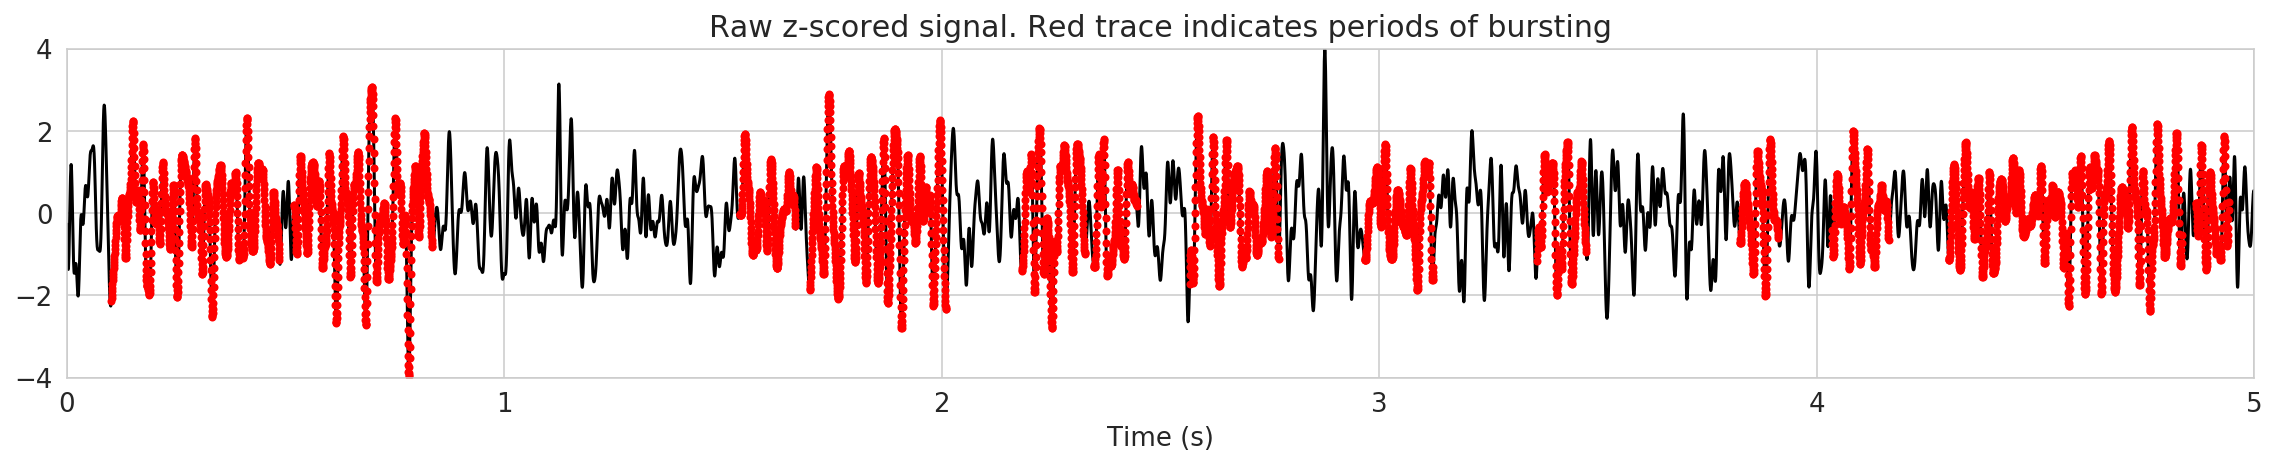

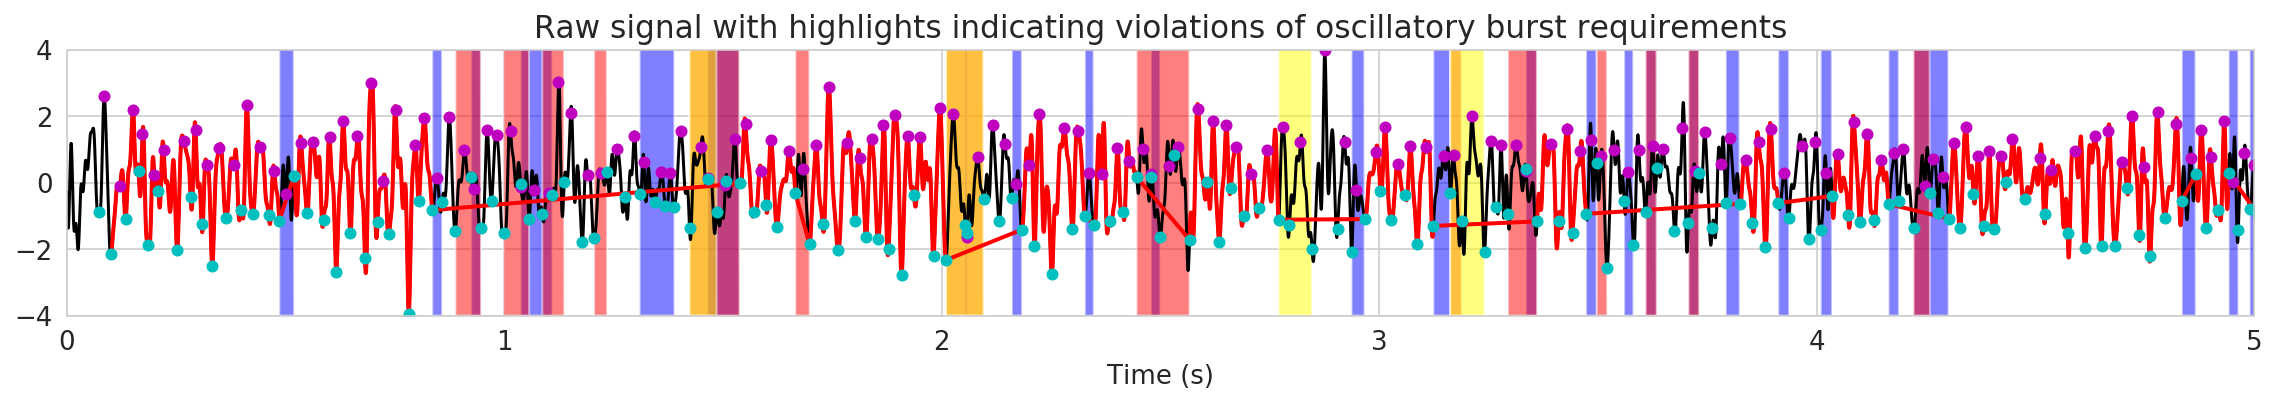

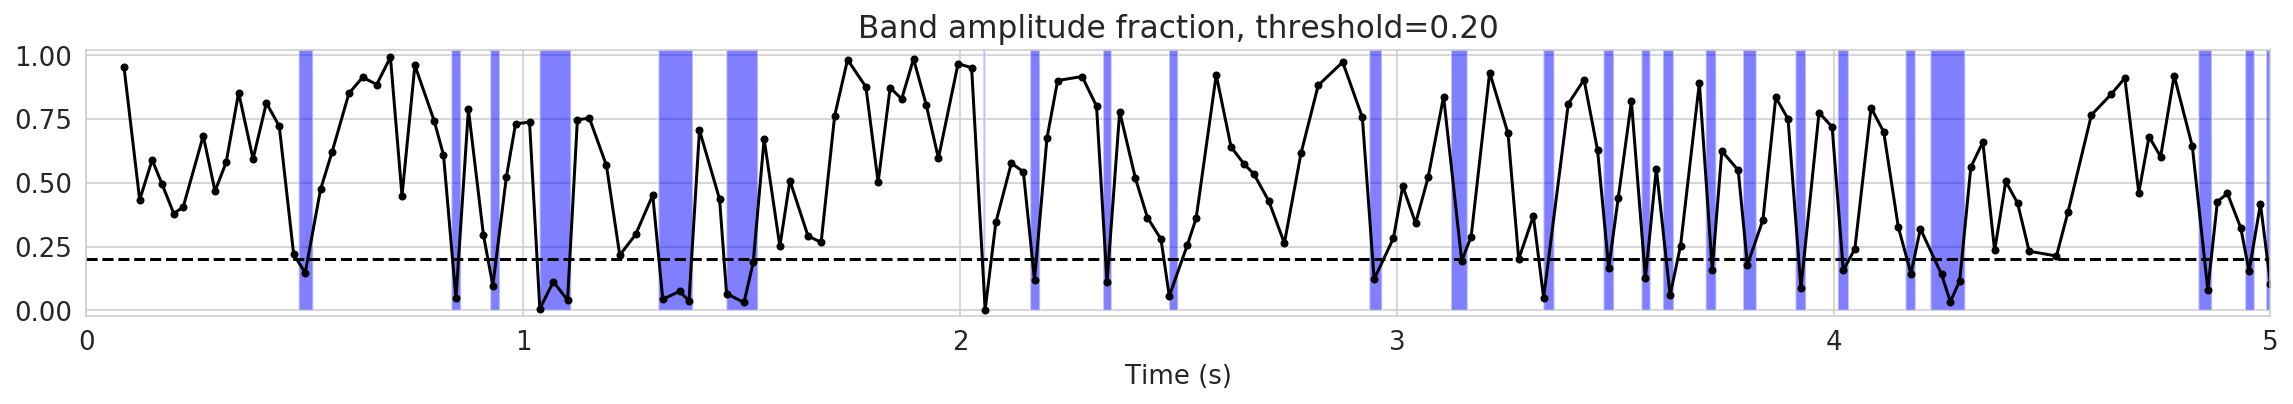

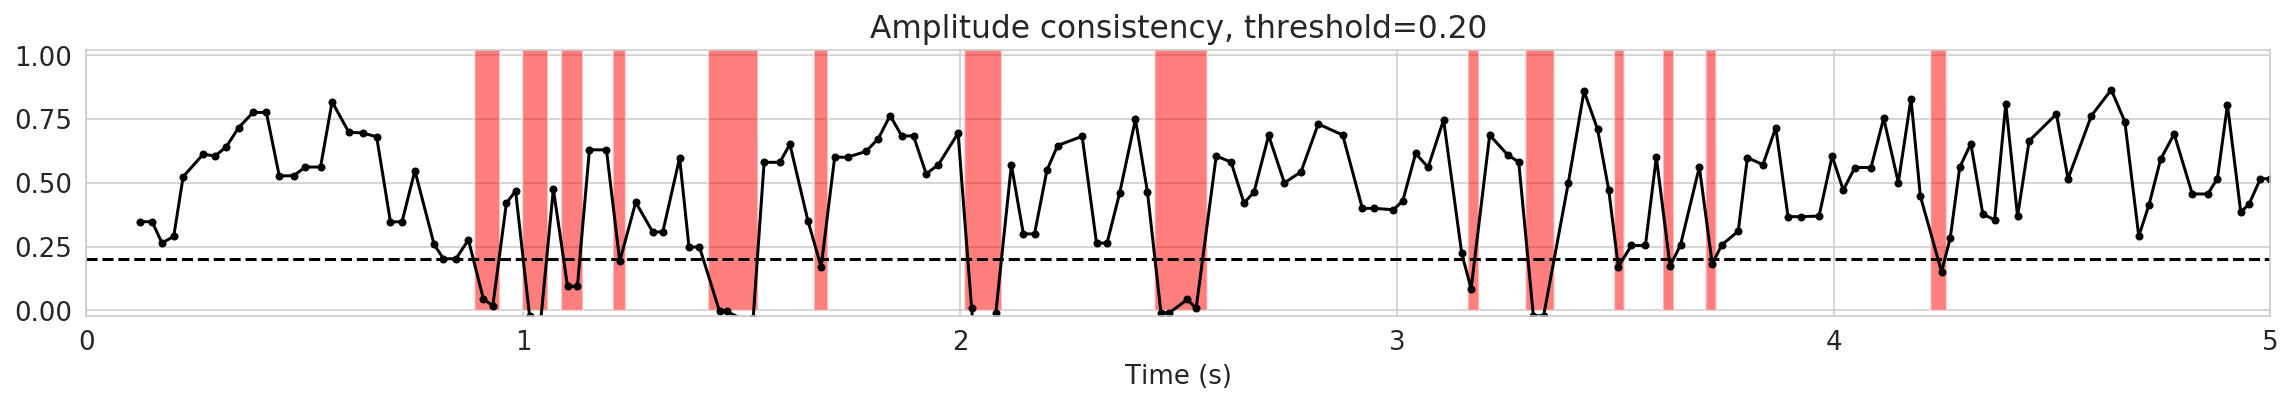

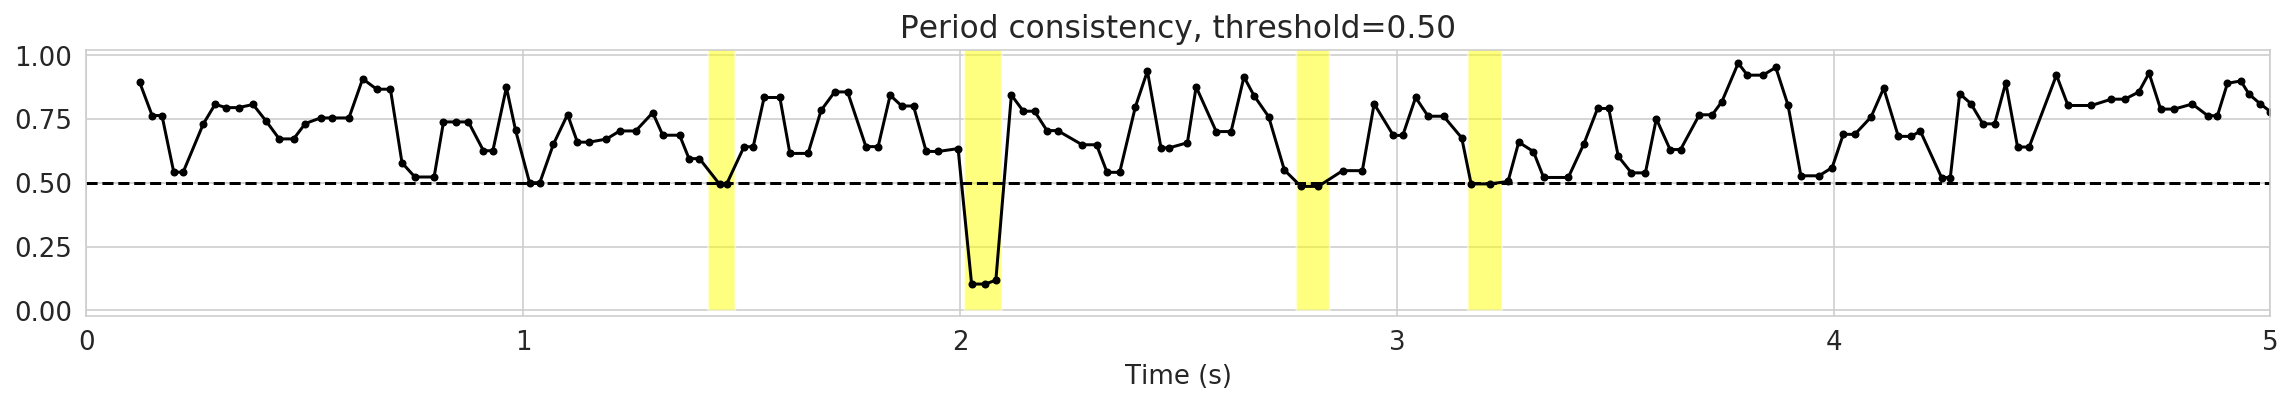

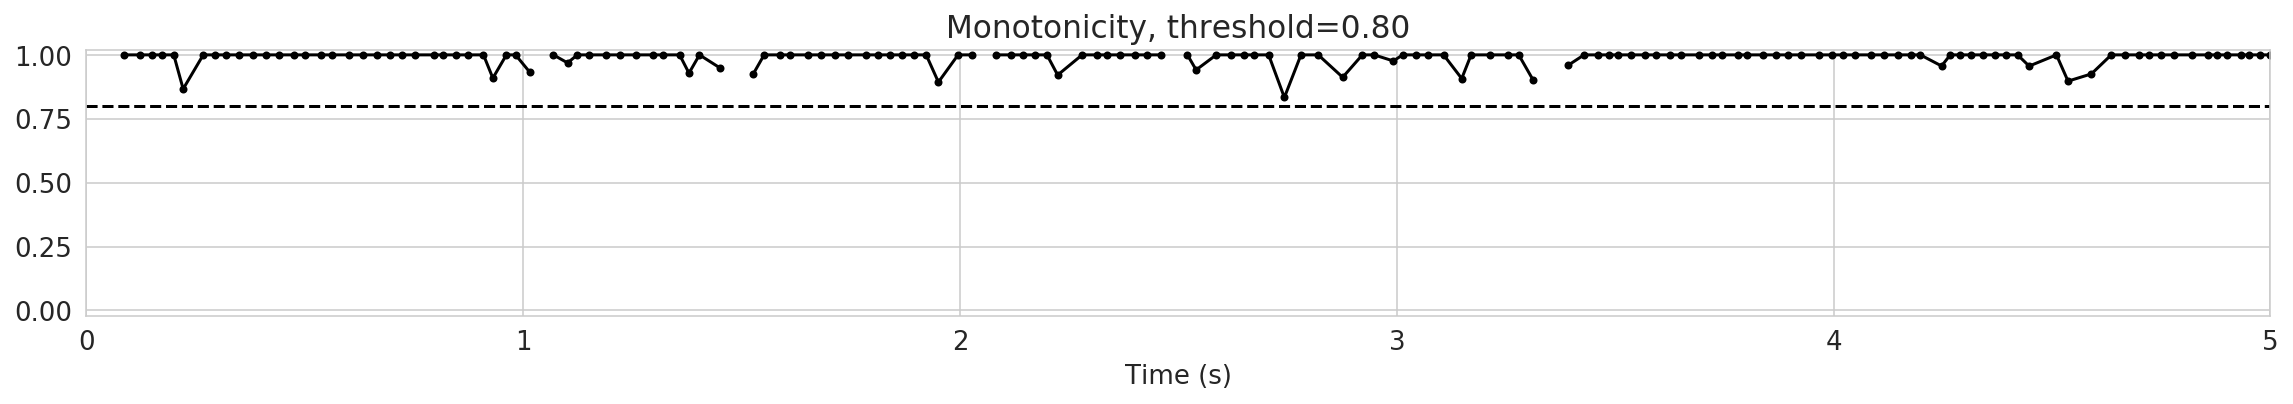

In [176]:
chan = 1
data_df = df_cycles[df_cycles['chan_id']==chan]

plot_burst_detect_params(data[chan], fs, data_df,
                         burst_kwargs, tlims=(0, 5), figsize=(16, 3), plot_only_result=True)

plot_burst_detect_params(data[chan], fs, data_df,
                         burst_kwargs, tlims=(0, 5), figsize=(16, 3))

In [177]:
# Only consider cycles that were identified to be in bursting regimes
df_cycles_burst = df_cycles[df_cycles['is_burst']]

# Compute average features across subjects in a recording
features_keep = ['volt_amp', 'period', 'time_rdsym', 'time_ptsym']
df_chans = df_cycles_burst.groupby(['chan_id']).mean()[features_keep].reset_index()
print(df_chans)

   chan_id  volt_amp     period  time_rdsym  time_ptsym
0        0  0.018760  63.219780    0.489002    0.509932
1        1  0.020943  63.308140    0.493779    0.504724
2        2  0.071268  60.308036    0.494272    0.498674
3        3  0.076572  60.226601    0.495360    0.501494
